In [ ]:
import pandas as pd
import numpy as np
import os
import json

from tqdm import tqdm

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_PROJECT = '''/content/drive/MyDrive/UCSD/02_Courses_UCSD/04_Fall_Term_2023/01_Advanced_Data_Mining/DSC_250_PROJECT'''
PATH_DATA = os.path.join(PATH_PROJECT, 'datasets')

aggregated_folder = 'AGGREGATED_DATA'
PATH_AGG_DATA = os.path.join(PATH_DATA, aggregated_folder)

#### Consolidating Financial Data

In [ ]:
PATH_PRICE_DATA = os.path.join(PATH_DATA, 'price/raw')

In [ ]:
stock_data_files = [file for file in os.listdir(PATH_PRICE_DATA) if '.csv' in file]

In [ ]:
stock_data_all = pd.DataFrame()
for file_name in tqdm(stock_data_files, position=0):
    ticker = file_name.split('.')[0]
    file_data = pd.read_csv(os.path.join(PATH_PRICE_DATA, file_name))
    file_data['ticker'] = ticker
    # Aggregating all the datasets
    stock_data_all = pd.concat([stock_data_all, file_data], axis=0)

In [ ]:
stock_data_all.columns = [x.lower() for x in stock_data_all.columns]

In [ ]:
# Storing the data in the Aggregated Directory
stock_data_all.to_csv(os.path.join(PATH_AGG_DATA, 'financial_data.csv'), index=False)

In [ ]:
# Reading the data again from the Aggregated Directory
stock_data_all = pd.read_csv(os.path.join(PATH_AGG_DATA, 'financial_data.csv'))

## Adding Tweet Vectors

In [ ]:
# Reading Tweet data
tweets = pd.read_csv(os.path.join(PATH_AGG_DATA, 'tweet_embeddings_all_agg.csv'))

In [ ]:
tweets.head()

,ticker,date,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,...,t2ve_506,t2ve_507,t2ve_508,t2ve_509,t2ve_510,t2ve_511,t2ve_512,tweet_sent_negative,tweet_sent_positive,tweet_sentiment_score
0,AAPL,2013-12-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.009038,0.024683,0.014230,-0.005057,0.036838,-0.034250,0.042868,1.0,0.0,0.976285
1,AAPL,2014-01-01,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006272,0.038048,0.028415,-0.003747,0.028702,-0.046322,0.019313,6.0,2.0,0.945411
2,AAPL,2014-01-02,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003726,0.038268,0.026364,-0.009559,0.031142,-0.054542,-0.013422,18.0,14.0,0.972707
3,AAPL,2014-01-03,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007831,0.034383,0.044858,-0.010264,0.029918,-0.045999,0.008392,16.0,5.0,0.974000
4,AAPL,2014-01-04,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.014244,0.015553,0.025035,-0.018254,0.044570,-0.054826,0.017356,4.0,1.0,0.969403


## Adding News Vectors

In [ ]:
news = pd.read_csv(os.path.join(PATH_AGG_DATA, 'news_final_agg.csv'), index_col=0)

In [ ]:
news.columns = [x.lower() for x in news]

#### Merging data

In [ ]:
min_date_fin, min_date_twe, min_date_new = stock_data_all['date'].min(), tweets['date'].min(), news['date'].min()
max_date_fin, max_date_twe, max_date_new = stock_data_all['date'].max(), tweets['date'].max(), news['date'].max()

In [ ]:
new_min = max(min_date_fin, min_date_twe, min_date_new)
new_max = min(max_date_fin, max_date_twe, max_date_new)

### Merging Financial and Tweets Vectors

In [ ]:
fin_tickers = stock_data_all['ticker'].drop_duplicates().to_list()
twe_tickers = tweets['ticker'].drop_duplicates().to_list()
[x for x in fin_tickers if x not in twe_tickers]

['RDS-B', 'BRK-A', 'GMRE']

In [ ]:
stock_data_merged = stock_data_all[(stock_data_all['date']>=new_min) & (stock_data_all['date']<=new_max)]\
          .merge(tweets[(tweets['date']>=new_min) & (tweets['date']<=new_max)], on=['date', 'ticker'], how='left')\
          .merge(news[(news['date']>=new_min) & (news['date']<=new_max)], on=['date', 'ticker'], how='left')

In [ ]:
stock_data_merged = stock_data_merged.groupby(['ticker'], as_index=False).apply(lambda df: df.fillna(method='ffill')).dropna(how='any')

<ipython-input-46-3318b44d1a55>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  stock_data_merged = stock_data_merged.groupby(['ticker'], as_index=False).apply(lambda df: df.fillna(method='ffill')).dropna(how='any')


In [ ]:
stock_data_merged

,date,open,high,low,close,adj close,volume,ticker,tp_0,tp_1,...,news2ve_119,news2ve_120,news2ve_121,news2ve_122,news2ve_123,news2ve_124,news2ve_125,news2ve_126,news2ve_127,news2ve_128
11665,2014-01-07,25.540001,25.730000,25.469999,25.590000,22.802778,19665100.0,INTC,3.0,0.0,...,-0.955092,1.272516,2.270106,5.061234,-3.365987,-0.318244,0.469105,-1.173529,-0.916900,1.116771
11666,2014-01-08,25.639999,25.709999,25.299999,25.430000,22.660204,29680500.0,INTC,1.0,0.0,...,-0.955092,1.272516,2.270106,5.061234,-3.365987,-0.318244,0.469105,-1.173529,-0.916900,1.116771
11667,2014-01-09,25.420000,25.549999,25.250000,25.309999,22.553270,20878000.0,INTC,1.0,0.0,...,-0.955092,1.272516,2.270106,5.061234,-3.365987,-0.318244,0.469105,-1.173529,-0.916900,1.116771
11668,2014-01-10,25.500000,25.850000,25.500000,25.530001,22.749315,30588800.0,INTC,1.0,0.0,...,-0.955092,1.272516,2.270106,5.061234,-3.365987,-0.318244,0.469105,-1.173529,-0.916900,1.116771
11669,2014-01-13,25.629999,25.990000,25.420000,25.500000,22.722576,40274500.0,INTC,3.0,0.0,...,-0.955092,1.272516,2.270106,5.061234,-3.365987,-0.318244,0.469105,-1.173529,-0.916900,1.116771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48265,2016-03-24,112.129997,113.089996,111.680000,113.050003,113.050003,17839100.0,FB,8.0,0.0,...,0.471167,0.474961,1.464210,-0.220930,-0.001917,0.880065,0.440760,-0.268412,-0.359327,0.735459
48266,2016-03-28,113.320000,114.589996,112.949997,113.690002,113.690002,21351800.0,FB,14.0,0.0,...,0.430381,-0.564250,-0.796871,1.069462,-1.367026,0.610496,0.094002,-0.112107,-0.794099,-0.884386
48267,2016-03-29,113.830002,116.320000,113.639999,116.139999,116.139999,29825300.0,FB,10.0,0.0,...,0.430381,-0.564250,-0.796871,1.069462,-1.367026,0.610496,0.094002,-0.112107,-0.794099,-0.884386
48268,2016-03-30,116.730003,116.989998,114.360001,114.699997,114.699997,33235200.0,FB,17.0,0.0,...,0.430381,-0.564250,-0.796871,1.069462,-1.367026,0.610496,0.094002,-0.112107,-0.794099,-0.884386


In [ ]:
# Storing the data (financial + tweets) in the Aggregated Directory
stock_data_merged.to_csv(os.path.join(PATH_AGG_DATA, 'financial_tweets_news_data.csv'), index=False)

<Axes: >

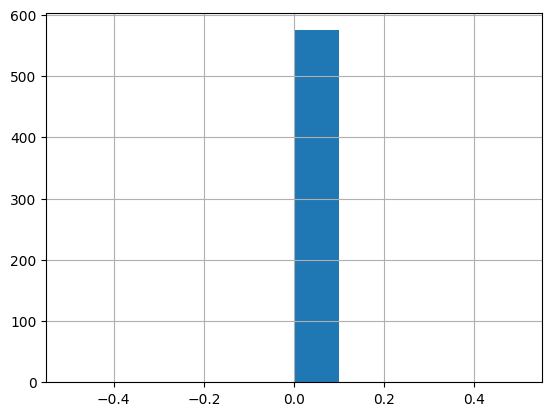

In [ ]:
stock_data_merged.isnull().mean().hist()

In [ ]:
# Reading the data again from the Aggregated Directory (Financial + Tweets)
stock_data_merged2 = pd.read_csv(os.path.join(PATH_AGG_DATA, 'financial_tweets_data.csv'))

In [ ]:
stock_data_merged2.isnull().mean().value_counts()

0.0    575
dtype: int64

## Adding News Vectors

In [ ]:
news

,Date,ticker,News_SScore,NegSenCount_news,PosSenCount_news,news2ve_001,news2ve_002,news2ve_003,news2ve_004,news2ve_005,...,news2ve_119,news2ve_120,news2ve_121,news2ve_122,news2ve_123,news2ve_124,news2ve_125,news2ve_126,news2ve_127,news2ve_128
0,2011-07-06,005930.KS,-0.998924,1,0,-1.010626,-1.703238,-0.413511,0.389713,2.163167,...,0.207646,1.655146,0.889079,1.486760,-1.184951,-0.201042,0.472570,-0.201521,1.017336,-0.113666
1,2011-07-06,AAPL,-0.999012,1,0,-0.157108,-0.571859,0.032514,0.166861,0.729311,...,-0.760558,0.543086,0.346933,0.051830,-0.204596,0.859705,0.747626,-0.776559,0.479887,-0.620001
2,2011-07-06,GOOG.O,-0.880484,1,0,-0.856936,0.664619,-1.106251,-0.652251,-0.023104,...,0.391603,-0.588558,-1.007424,-0.152823,-0.645491,0.437398,0.711479,1.316568,-0.006403,2.237492
3,2011-07-06,MSFT,-0.880484,1,0,-1.031037,0.600716,-0.877446,-0.503262,0.082519,...,0.163881,-0.449097,-0.891018,-0.108985,-0.616514,0.161821,0.581170,0.997624,0.134090,2.186701
4,2011-07-06,SNE,-0.999250,1,0,-0.111641,-0.966836,-0.199753,0.158541,1.464830,...,-0.786741,0.292438,0.738226,0.779165,-0.493808,1.259018,0.158851,-0.807277,-0.015396,-0.971534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15475,2017-07-21,F,-0.985763,1,0,-0.144363,0.006910,0.221121,-0.177684,-0.724690,...,-1.205858,3.942832,-0.272403,-1.954902,-2.787234,3.925621,1.017648,-1.646136,-1.222323,0.044086
15476,2017-07-21,GE,-0.999422,1,0,-0.575802,-1.386625,0.915792,1.177033,2.023609,...,0.664791,-0.775219,0.776399,-0.448805,-2.578633,0.665849,1.016674,-0.815386,0.206658,0.469994
15477,2017-07-21,WFC,0.000864,1,1,-0.431103,1.175944,-2.952086,-0.780469,1.060984,...,1.480217,1.475209,0.877700,-1.774790,-1.566558,0.212654,0.784116,0.890200,0.980076,-0.187412
15478,2017-07-21,WMT,0.997321,0,1,0.842505,-0.895908,0.038391,-0.118975,0.286862,...,-0.277471,-1.063922,1.309445,-0.157783,-0.172332,0.773345,-1.077293,-0.386477,-1.244690,-0.331495


In [ ]:
os.path.join(PATH_AGG_DATA, 'financial_tweets_data.csv')

'/content/drive/MyDrive/UCSD/02_Courses_UCSD/04_Fall_Term_2023/01_Advanced_Data_Mining/DSC_250_PROJECT/datasets/AGGREGATED_DATA/financial_tweets_data.csv'

In [ ]:
ls /content/drive/MyDrive/DSC250_project/DSC_250_PROJECT/datasets/AGGREGATED_DATA/

financial_data.csv         news.csv     news_upd.csv     tweet_embeddings_all_agg.csv
financial_tweets_data.csv  news.gsheet  news_upd.gsheet


In [ ]:
fintweet = os.path.join('/content/drive/MyDrive/DSC250_project/DSC_250_PROJECT/datasets/AGGREGATED_DATA/','financial_tweets_data.csv')

In [ ]:
fintweetdf = pd.read_csv(fintweet)

In [ ]:
fintweetdf[fintweetdf['t2ve_503'].notna()]

,date,open,high,low,close,adj close,volume,ticker,tp_0,tp_1,...,t2ve_503,t2ve_504,t2ve_505,t2ve_506,t2ve_507,t2ve_508,t2ve_509,t2ve_510,t2ve_511,t2ve_512
334,2014-01-03,26.900000,26.969999,26.450001,26.620001,23.102039,10155900.0,EXC,2.0,0.0,...,-0.039745,0.049885,0.049517,0.028167,-0.002782,0.042019,-0.011090,0.042597,-0.011800,0.017457
335,2014-01-06,26.610001,26.860001,26.549999,26.790001,23.249571,7416700.0,EXC,0.0,0.0,...,-0.023691,0.018364,0.044739,0.074147,-0.082186,-0.007602,-0.022728,-0.059540,-0.030254,0.005696
353,2014-01-31,28.799999,29.309999,28.780001,29.000000,25.167509,10412300.0,EXC,1.0,0.0,...,-0.009917,0.042944,0.046632,0.058104,0.085492,0.036644,0.030702,0.027712,-0.053071,0.024938
357,2014-02-06,28.809999,29.879999,28.809999,29.490000,25.592754,13763200.0,EXC,0.0,0.0,...,0.017460,0.032133,0.084037,0.052211,0.059264,-0.047991,0.005561,0.016215,-0.011814,-0.047678
359,2014-02-10,29.350000,29.549999,29.230000,29.400000,25.514645,7130200.0,EXC,0.0,0.0,...,-0.010056,0.047333,-0.063138,-0.024505,-0.009900,-0.012198,0.025965,0.005738,-0.007629,-0.035721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108227,2016-03-24,73.510002,73.589996,73.029999,73.419998,69.355751,1594600.0,D,0.0,0.0,...,0.041545,-0.108021,0.087215,-0.016294,-0.041175,0.031191,-0.031955,-0.051584,0.023691,-0.059163
108228,2016-03-28,73.639999,74.040001,73.000000,73.150002,69.100708,1977000.0,D,1.0,2.0,...,0.018712,-0.053778,0.046652,0.006235,-0.012861,0.037988,-0.023200,-0.009246,0.001844,-0.044079
108229,2016-03-29,73.470001,74.699997,73.089996,74.639999,70.508217,2752800.0,D,0.0,1.0,...,0.021798,-0.077087,0.060280,-0.001583,-0.016892,0.032099,-0.035189,-0.034737,0.003649,-0.060289
108230,2016-03-30,74.790001,74.900002,74.099998,74.750000,70.612137,1958600.0,D,0.0,0.0,...,-0.007067,0.024504,0.035780,0.021117,-0.004750,0.034037,-0.017825,0.023000,-0.036531,-0.044618


In [ ]:
newspath = os.path.join('/content/drive/MyDrive/DSC250_project/DSC_250_PROJECT/datasets/AGGREGATED_DATA/','news_upd.csv')

In [ ]:
newsdf = pd.read_csv(newspath, encoding='latin-1', parse_dates= [1], lineterminator='\n')

In [ ]:
newsdf['Date'] = pd.to_datetime(newsdf['Date'], errors='coerce')

In [ ]:
newsdf_agg = newsdf.groupby('Date', 'ticker').agg({})

In [ ]:
np.unique(newsdf['Title sentiment_label'])

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [ ]:
newsdf[]

In [ ]:
newsdf[newsdf['Date']=='2011-07-12']

,Date,Title,Body,ticker,tokenized_words,cleaned_text,Title sentiment_label,Title sentiment_score,newsVector
18,2011-07-12,Obama holding lunch mtg with business execs on...,"washington, july 12 president barack obama wa...",T,"['washington', ',', 'july', '12', 'president',...","['washington', 'july', '12', 'president', 'bar...",NEGATIVE,0.972524,[-5.4592901e-01 -5.7942414e-01 2.1099211e-01 ...
468,2011-07-12,Regulators combat unauthorized phone bill fees...,washington telephone companies would have to m...,T,"['washington', 'telephone', 'companies', 'woul...","['washington', 'telephone', 'companies', 'woul...",NEGATIVE,0.983715,[ 2.1390417 1.1236602 -2.027831 1.788465...
1124,2011-07-12,Electronic Arts buying PopCap Games for up to ...,"new york electronic arts inc , the video game ...",GOOG.O,"['new', 'york', 'electronic', 'arts', 'inc', '...","['new', 'york', 'electronic', 'arts', 'inc', '...",NEGATIVE,0.999164,[-0.37570712 -3.498245 -0.39497977 0.146711...
2026,2011-07-12,UPDATE 1-Firestone wins Liberian child labor c...,* companies can be held liable for human-righ...,XOM,"['*', 'companies', 'can', 'be', 'held', 'liabl...","['companies', 'held', 'liable', 'abuses', 'abr...",POSITIVE,0.999353,[-2.1302390e+00 5.4395765e-02 -2.9384639e+00 ...
2893,2011-07-12,Regulators combat unauthorized phone bill fees...,washington telephone companies would have to m...,VZ,"['washington', 'telephone', 'companies', 'woul...","['washington', 'telephone', 'companies', 'woul...",NEGATIVE,0.976724,[-6.2695724e-01 2.8825265e-01 -1.5188003e+00 ...
3395,2011-07-12,"Apple chief patent lawyer leaving: sources,Tos...",san francisco apple inc's chief patent counsel...,005930.KS,"['san', 'francisco', 'apple', 'inc', ""'s"", 'ch...","['san', 'francisco', 'apple', 'inc', 'chief', ...",NEGATIVE,0.993491,[-1.9358366 -0.64709556 -0.0476862 1.592252...
4948,2011-07-12,Electronic Arts buying PopCap Games for up to ...,"new york electronic arts inc , the video game ...",AAPL,"['new', 'york', 'electronic', 'arts', 'inc', '...","['new', 'york', 'electronic', 'arts', 'inc', '...",NEGATIVE,0.998376,[-1.8747267 -2.0403597 -1.3048285 0.518847...
6608,2011-07-12,Regulators combat unauthorized phone bill fees...,washington telephone companies would have to m...,WFC,"['washington', 'telephone', 'companies', 'woul...","['washington', 'telephone', 'companies', 'woul...",NEGATIVE,0.976724,[-0.63758945 0.5392483 -1.5211304 -1.144361...
7111,2011-07-12,Analysis: Wal-Mart ruling no knock-out blow fo...,new york the end of the road for a class-actio...,WFC,"['new', 'york', 'the', 'end', 'of', 'the', 'ro...","['new', 'york', 'end', 'road', 'discrimination...",NEGATIVE,0.987345,[-1.3457037e+00 2.1614358e+00 -5.1890165e-01 ...
7920,2011-07-12,BRIEF-Moody's Downgrades Wells Fargo's Service...,"july 13, 2011 (reuters)--moody's downgrades we...",WFC,"['july', '13', ',', '2011', '(', 'reuters', ')...","['july', '13', '2011', 'reuters', 'moody', 'do...",NEGATIVE,0.945500,[-1.9909439 -0.46401983 -1.6327851 0.249815...
